In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(35, 145, 111)

df = pd.read_csv('2018-06-21_co_culture_t_35.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((111,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [5]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_9530/152966210.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     465     0:01.3
2     873     0:02.4
3     1293    0:03.4
20    6633    0:16.7
40    11454   0:28.9
60    15921   0:40.2
80    20505   0:51.8
100   24774   1:02.7
120   29322   1:14.4
140   33891   1:26.1
160   38292   1:37.4
180   42555   1:48.5
200   46941   1:59.9
220   51258   2:11.0
240   55626   2:22.3
260   60387   2:34.5
280   64734   2:45.8
300   69069   2:56.9
320   73362   3:08.1
340   78003   3:20.0
360   82323   3:31.1
380   86649   3:42.4
400   91170   3:54.0
420   95727   4:05.8
440   100257   4:17.5
460   104682   4:29.0
480   109332   4:41.0
500   113796   4:52.5
520   118224   5:03.9
540   122763   5:15.6
560   127194   5:27.0
580   131754   5:38.8
600   136179   5:50.3
620   140829   6:02.2
640   145059   6:13.1
660   149628   6:24.9
680   154389   6:37.0
700   158997   6:48.9
720   163599   7:00.8
740   168411   7:13.0
760   172830   7:24.5

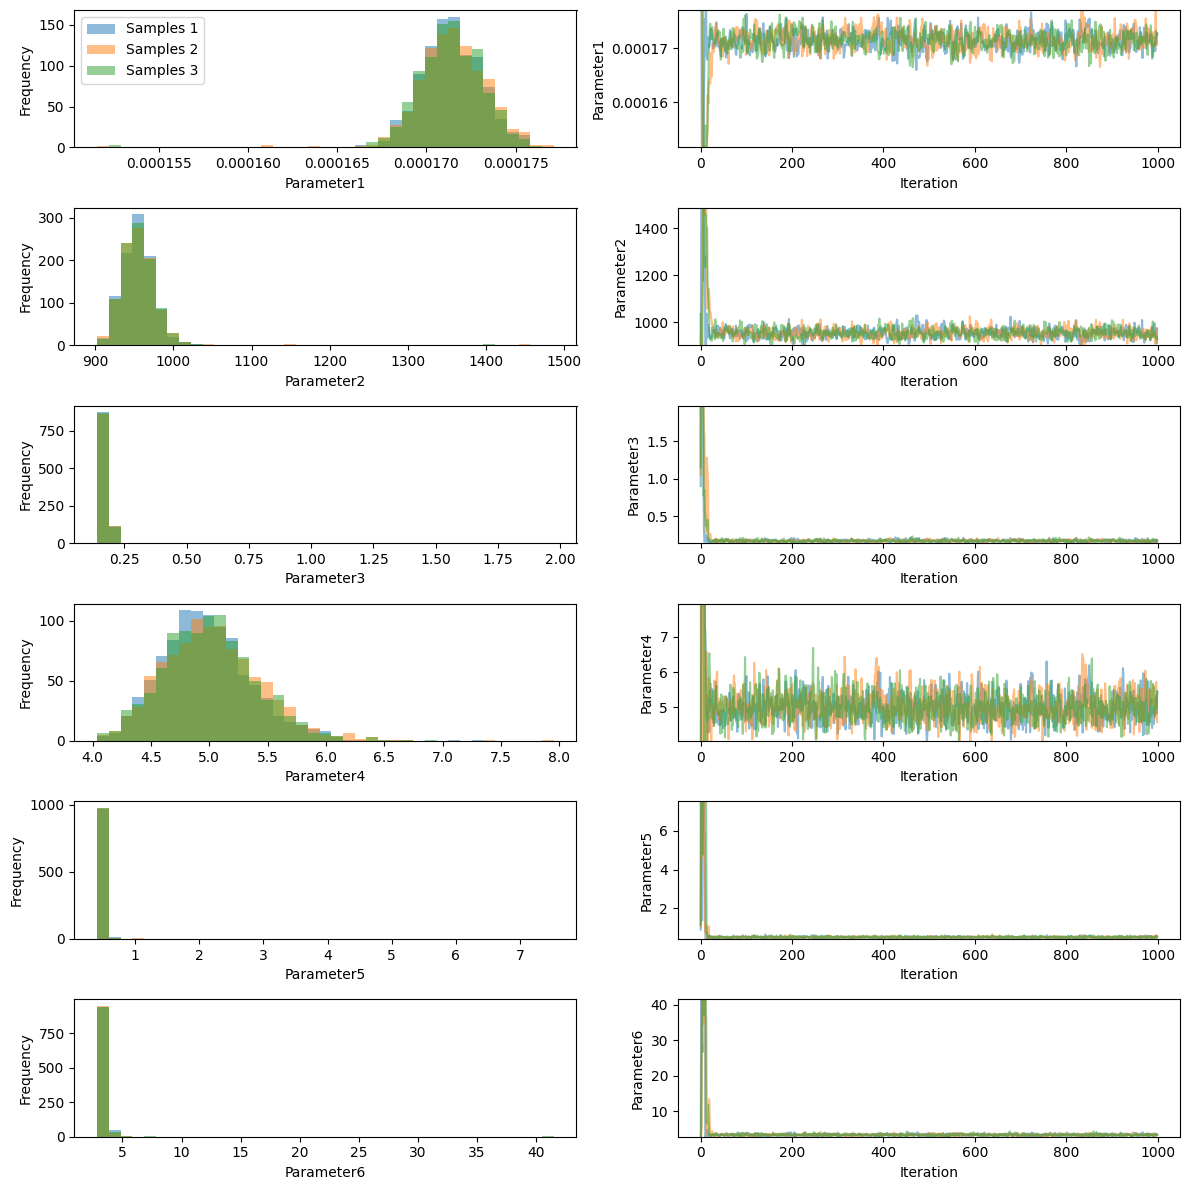

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 6)
[1.76413277e-04 9.18749763e+02 1.61372226e-01 5.88708965e+00
 5.17594522e-01 3.78888204e+00]
[[1.76413277e-04 9.18749763e+02 1.61372226e-01 5.88708965e+00
  5.17594522e-01 3.78888204e+00]
 [1.74094284e-04 9.66533368e+02 1.71179924e-01 5.11402541e+00
  4.74585924e-01 3.96976253e+00]
 [1.69225082e-04 9.50841777e+02 1.68383363e-01 4.85903163e+00
  4.94182878e-01 3.71949528e+00]
 ...
 [1.70911060e-04 9.36262321e+02 1.57705512e-01 5.07036654e+00
  4.99009050e-01 3.59424944e+00]
 [1.72289265e-04 9.10032296e+02 1.76875552e-01 4.82705010e+00
  5.21934362e-01 3.62392423e+00]
 [1.72860568e-04 9.73890869e+02 1.78986644e-01 5.45238153e+00
  5.32954816e-01 3.43934345e+00]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


In [10]:

y0 = np.array([0.0003,900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 1500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 1500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Estimated parameters:
[1.71377733e-04 9.53198811e+02 1.68055965e-01 4.91006371e+00
 4.92470543e-01 3.34526491e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(


Estimated parameters:
[1.71377734e-04 9.53198778e+02 1.68055941e-01 4.91006329e+00
 4.92470571e-01 3.34526509e+00]
Estimated parameters:
[1.71377730e-04 9.53198802e+02 1.68055966e-01 4.91006340e+00
 4.92470570e-01 3.34526520e+00]
Estimated parameters:
[1.71377731e-04 9.53198819e+02 1.68055956e-01 4.91006316e+00
 4.92470572e-01 3.34526504e+00]


In [11]:
print(log_likelihood([1.71377733e-04, 9.53198811e+02, 1.68055965e-01, 4.91006371e+00,
 4.92470543e-01, 3.34526491e+00]))

AIC = 2*6 - 2*log_likelihood([1.71377733e-04, 9.53198811e+02, 1.68055965e-01, 4.91006371e+00,
 4.92470543e-01, 3.34526491e+00])

print(AIC)

-664.0917041394704
1340.1834082789408


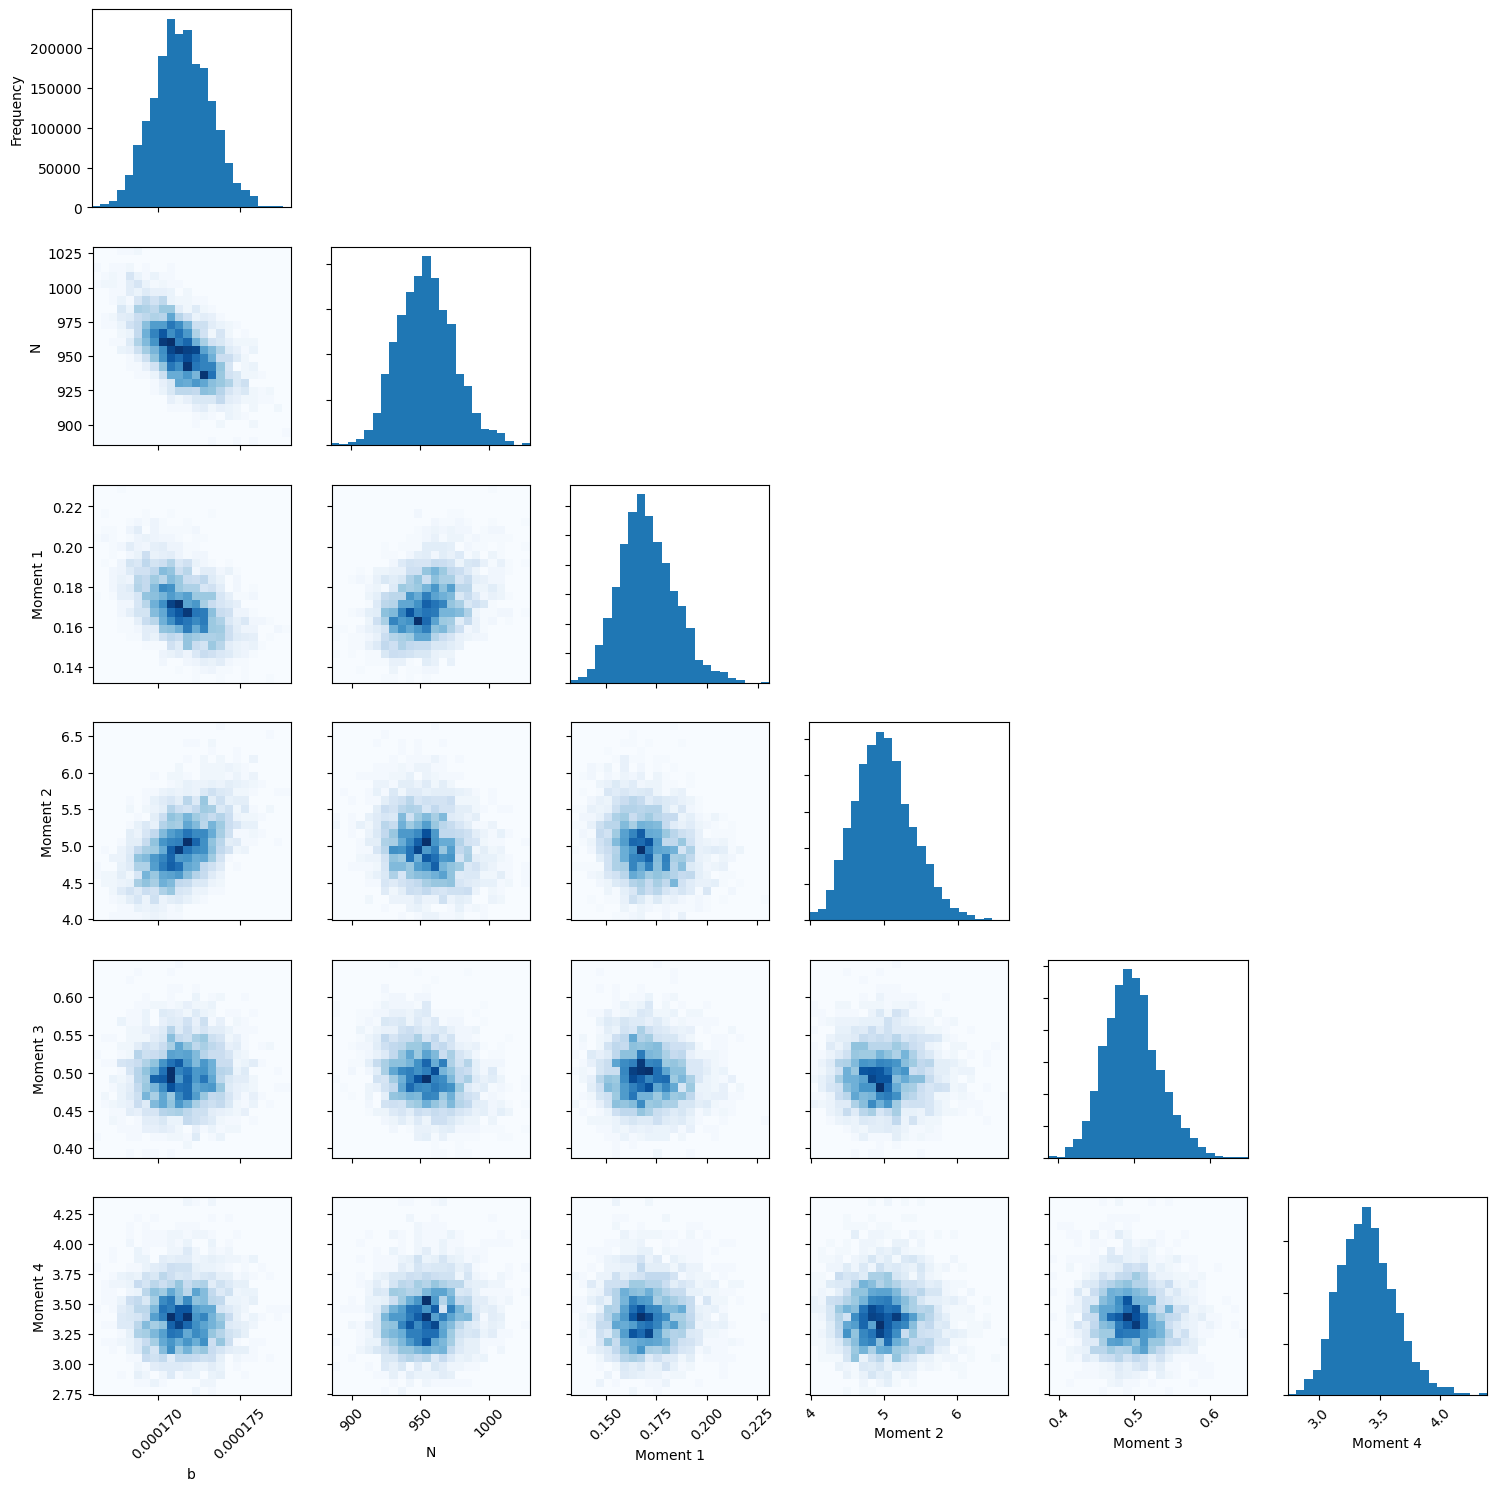

In [12]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

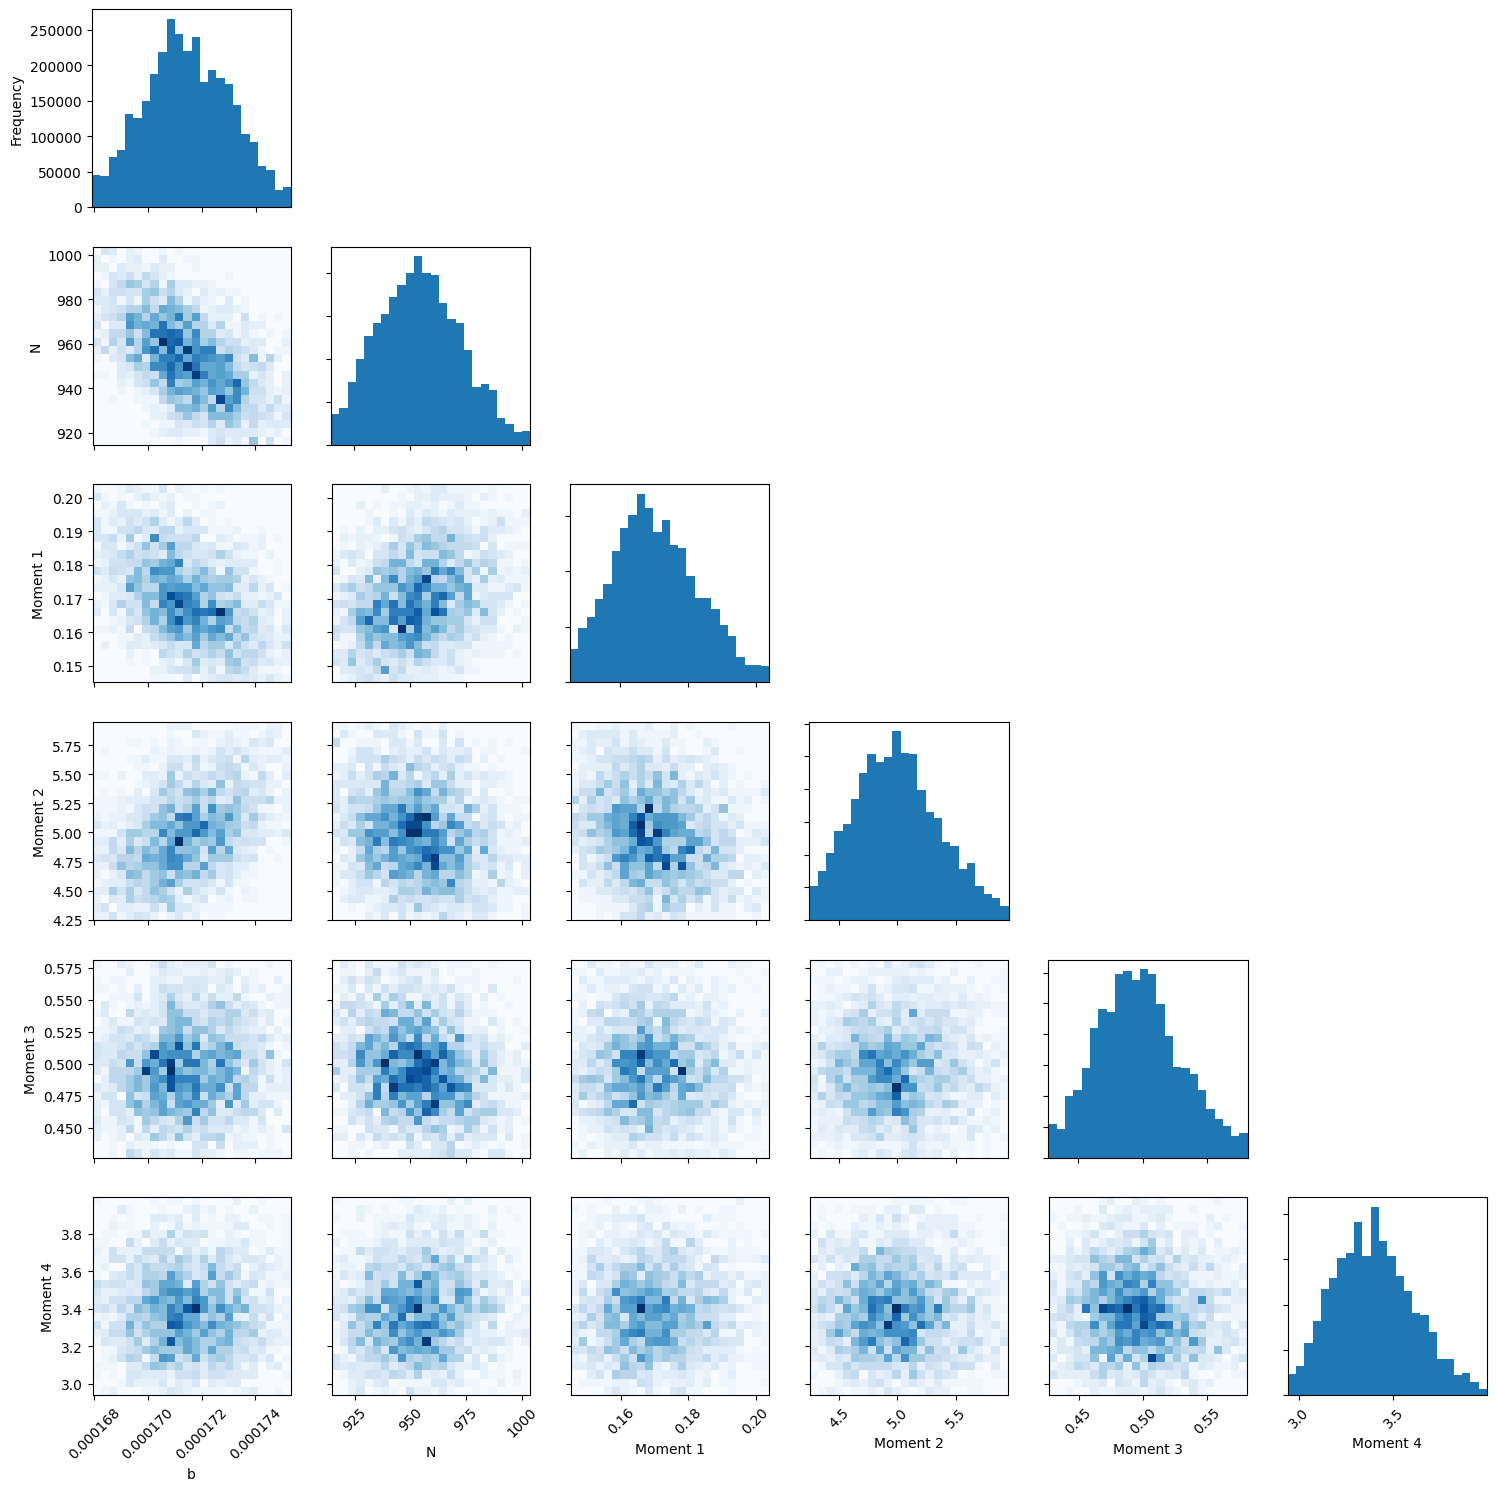

In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [15]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    254.48  0.44
N         954.64  19.85   917.81  941.05  954.34  967.54  996.35   1.00    304.79  0.53
Moment 1  0.17    0.01    0.15    0.16    0.17    0.18    0.20     1.00    365.90  0.64
Moment 2  4.99    0.39    4.30    4.72    4.97    5.22    5.78     1.00    354.01  0.62
Moment 3  0.50    0.04    0.43    0.47    0.50    0.52    0.57     1.00    466.80  0.81
Moment 4  3.40    0.24    2.98    3.23    3.39    3.55    3.89     1.00    461.30  0.80


In [16]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [17]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%      50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  -------  --------  --------  --------  ------  -----  --------------
b         0.000171  1.66e-06  0.000168  0.00017  0.000171  0.000173  0.000175  1       254    0.442
N         955       19.8      918       941      954       968       996       1       305    0.53
Moment 1  0.171     0.0133    0.147     0.161    0.17      0.179     0.199     1       366    0.636
Moment 2  4.99      0.389     4.3       4.72     4.97      5.22      5.78      1       354    0.615
Moment 3  0.498     0.0355    0.432     0.473    0.495     0.519     0.571     1       467    0.811
Moment 4  3.4       0.237     2.98      3.23     3.39      3.55      3.89      1       461    0.802


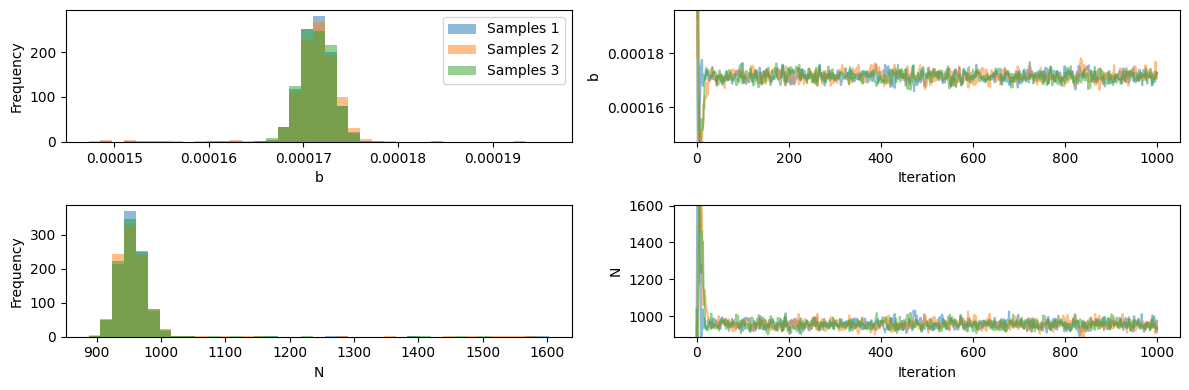

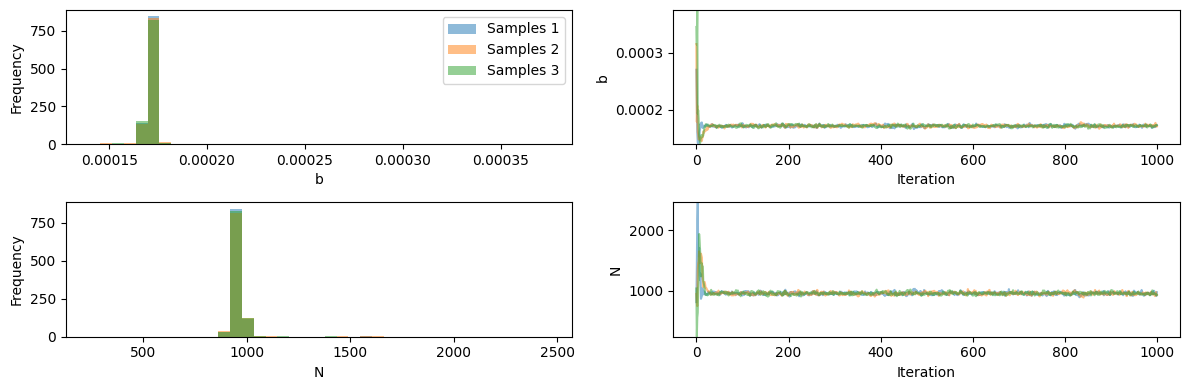

In [18]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

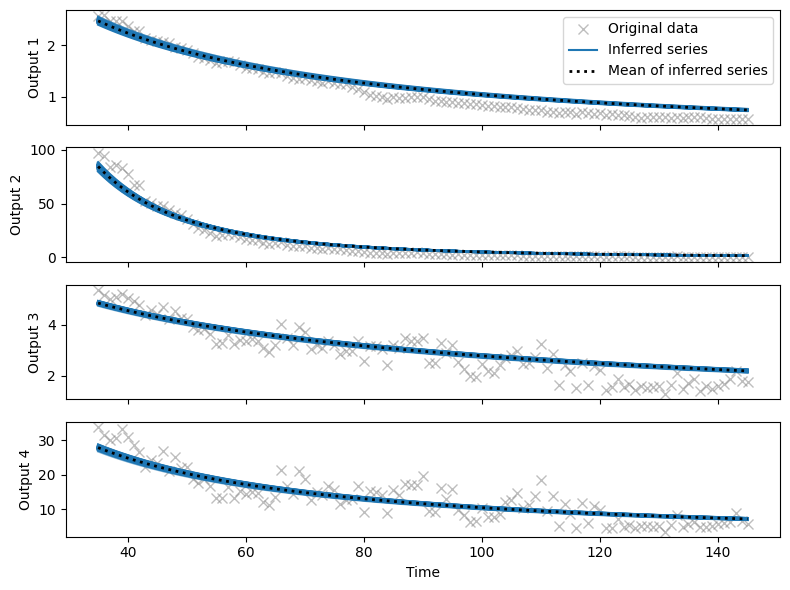

In [19]:
fig, axes = pints.plot.series(AllChains, problem)